In [ ]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn

from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
import numpy as np
from IPython.display import Markdown as md
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import pickle
from transformers import AutoTokenizer, AutoModel

from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from datasets import load_dataset

dataset = load_dataset("fancyzhx/ag_news")

In [ ]:
# print first 5 rows in dataset as df pandas
import pandas as pd
df = pd.DataFrame(dataset["train"])
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


# Load Data

In [ ]:
dataset = load_dataset("ag_news")
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# AG News Labels: 0=World, 1=Sports, 2=Business, 3=Sci/Tech
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def tokenize_function(examples):
    tokenized_inputs = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
    tokenized_inputs["text"] = examples["text"]  # Add the original text back
    return tokenized_inputs

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels", "text"])

In [ ]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(2000))
test_dataset = tokenized_datasets["test"].select(range(500))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Pre-Training Evaluation

In [ ]:
def predict_custom_text(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()
    return id2label[predicted_class_id]

In [ ]:
import random

def evaluate_sample_predictions(model, tokenizer, dataset, n_samples=7):
    print("Sample Predictions (Before Fine-tuning)")

    samples = random.sample(range(len(dataset)), n_samples)

    labels_list = dataset.features['labels'].names  # Changed 'label' to 'labels'

    for idx in samples:
        sample = dataset[idx]
        text = sample["text"]
        true_label = labels_list[sample["labels"]] # Changed 'label' to 'labels'

        # Tokenization + prediction
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            pred_label_idx = outputs.logits.argmax(dim=1).item()
            pred_label = labels_list[pred_label_idx]

        print(f"Text: {text}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}")
        print("-"*80)


In [ ]:
evaluate_sample_predictions(model, tokenizer, test_dataset, n_samples=15)

Sample Predictions (Before Fine-tuning)
Text: Natalie Coughlin Wins 100M Backstroke (AP) AP - American Natalie Coughlin won Olympic gold in the 100-meter backstroke Monday night. Coughlin, the only woman ever to swim under 1 minute in the event, finished first in 1 minute, 0.37 seconds. Kirsty Coventry of Zimbabwe, who swims at Auburn University in Alabama, earned the silver in 1:00.50. Laure Manaudou of France took bronze in 1:00.88.
True Label: Sports
Predicted Label: Business
--------------------------------------------------------------------------------
Text: Fischer's Fiancee: Marriage Plans Genuine (AP) AP - Former chess champion Bobby Fischer's announcement thathe is engaged to a Japanese woman could win him sympathy among Japanese officials and help him avoid deportation to the United States, his fiancee and one of his supporters said Tuesday.
True Label: World
Predicted Label: Business
--------------------------------------------------------------------------------
Text: Gree

# Training Loop

In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler
import torch.nn as nn # Added import for nn.CrossEntropyLoss

def evaluate_and_track(dataloader, model, criterion=None):
    """
    Evaluate model on a dataloader, compute accuracy and optionally average loss.
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Filter out 'text' column and move only tensor items to device
            model_inputs = {k: v.to(device) for k, v in batch.items() if k != 'text'}

            outputs = model(**model_inputs)
            logits = outputs.logits
            labels = model_inputs["labels"]

            # Accuracy
            predictions = logits.argmax(dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Loss
            if criterion:
                loss = criterion(logits, labels)
                total_loss += loss.item() * labels.size(0)  # sum over batch

    avg_loss = total_loss / total if criterion else None
    accuracy = correct / total
    return accuracy, avg_loss

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))

criterion = nn.CrossEntropyLoss()

train_loss_history = []
train_acc_history = []
val_acc_history = []

print("Start Training")
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in train_loader:
        # Filter out 'text' column and move only tensor items to device
        model_inputs = {k: v.to(device) for k, v in batch.items() if k != 'text'}
        labels = model_inputs["labels"]

        outputs = model(**model_inputs)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        total_loss += loss.item()

        predictions = outputs.logits.argmax(dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples

    train_loss_history.append(avg_loss)
    train_acc_history.append(train_accuracy)

    print(f"Epoch {epoch+1} finished. Average Loss: {avg_loss:.4f} - Training Accuracy: {train_accuracy:.4f}")

    # Evaluate on test set after each epoch for validation accuracy
    model.eval()
    val_accuracy, _ = evaluate_and_track(test_loader, model, criterion=None) # Use test_loader
    val_acc_history.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

  0%|          | 0/375 [00:00<?, ?it/s]

Start Training


 33%|███▎      | 125/375 [00:43<01:30,  2.78it/s]

Epoch 1 finished. Average Loss: 0.5246 - Training Accuracy: 0.8290



 34%|███▎      | 126/375 [00:47<06:26,  1.55s/it]

Validation Accuracy: 0.8840


 67%|██████▋   | 250/375 [01:30<00:46,  2.71it/s]

Epoch 2 finished. Average Loss: 0.2059 - Training Accuracy: 0.9395



 67%|██████▋   | 251/375 [01:34<03:00,  1.46s/it]

Validation Accuracy: 0.8760


100%|██████████| 375/375 [02:17<00:00,  2.86it/s]

Epoch 3 finished. Average Loss: 0.0880 - Training Accuracy: 0.9770



100%|██████████| 32/32 [00:03<00:00,  8.46it/s]

Validation Accuracy: 0.8680


# Blotting ( ACC & LOSS )

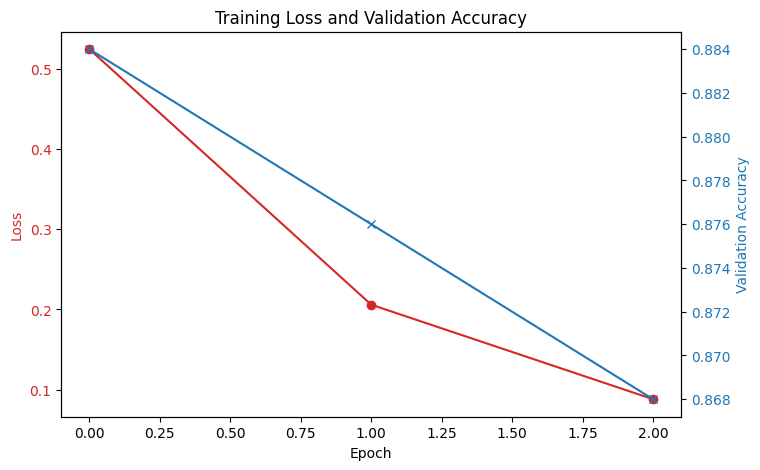

In [ ]:
def plot_metrics(loss_list, acc_list):
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(8,5))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(loss_list, color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation Accuracy', color=color)
    ax2.plot(acc_list, color=color, marker='x')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("Training Loss and Validation Accuracy")
    plt.show()

# Plot at the end
plot_metrics(train_loss_history, val_acc_history)

# Post-Training Evaluation

In [ ]:
import random

def show_sample_predictions(model, tokenizer, dataset, n_samples=7, title="Predictions"):
    print(f"\{title}")

    samples = random.sample(range(len(dataset)), n_samples)
    labels_list = dataset.features['labels'].names  # Changed 'label' to 'labels'

    for idx in samples:
        sample = dataset[idx]
        text = sample["text"]
        true_label = labels_list[sample["labels"]]  # Changed 'label' to 'labels'

        # Tokenization + prediction
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            pred_label_idx = outputs.logits.argmax(dim=1).item()
            pred_label = labels_list[pred_label_idx]

        print(f"Text: {text}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}")
        print("-"*80)

In [ ]:
show_sample_predictions(model, tokenizer, test_dataset, n_samples=15, title="After Fine-tuning")

\After Fine-tuning
Text: So. Cal Player Investigated in Sex Assault (AP) AP - At least one member of the top-ranked Southern California football team is under investigation for sexual assault, the Los Angeles Police Department said Tuesday.
True Label: Sports
Predicted Label: Sports
--------------------------------------------------------------------------------
Text: Seattle Mariners Minor League Report - August 23rd TACOMA RAINIERS - The Rainiers just missed a perfect week when they suffered their only setback on Sunday August 22nd, a 13-6 loss to the Portland Beavers.
True Label: Sports
Predicted Label: Sports
--------------------------------------------------------------------------------
Text: Israel Announces West Bank Housing Plans (AP) AP - Israel announced plans Monday for 500 new housing units in the West Bank, after an apparent U.S. policy shift that has infuriated the Palestinians. The Palestinians oppose all Jewish settlement in the West Bank and Gaza Strip, lands where th

In [ ]:
model.save_pretrained("./my_ag_news_model")
tokenizer.save_pretrained("./my_ag_news_model")
print("Model saved to ./my_ag_news_model")

Model saved to ./my_ag_news_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import os

source_folder = './my_ag_news_model'
destination_folder = '/content/drive/MyDrive/my_ag_news_model'

if os.path.exists(destination_folder):
    shutil.rmtree(destination_folder)

shutil.copytree(source_folder, destination_folder)
print(f"Folder '{source_folder}' saved to '{destination_folder}' on Google Drive.")

Mounted at /content/drive
Folder './my_ag_news_model' saved to '/content/drive/MyDrive/my_ag_news_model' on Google Drive.
